# Introduction to Project - Problem - Dataset

### Customer Segmentation Using Clustering Analysis

#### Introduction

This project explores unsupervised machine learning clustering techniques applied to customer segmentation using the Online Retail dataset from Kaggle. The goal is to discover natural groupings of customers based on their purchasing behavior, specifically their recency, frequency, and monetary value (RFM) while gaining hands-on experience with clustering algorithms, feature engineering, and unsupervised learning methodology. Unlike supervised learning (which predicts known outcomes), clustering discovers hidden patterns without predefined labels.

#### Problem Statement: 

An online retail business has transaction data but lacks insight into their customer base. Key business questions include: Which customers are most valuable? Which are at risk of leaving? Which represent growth opportunities? By segmenting customers into meaningful clusters based on their purchasing patterns, the business can tailor marketing strategies, optimize customer retention efforts, and allocate resources more effectively. Understanding these natural customer groupings enables data-driven decision-making around customer lifetime value, churn prediction, and targeted campaigns.

#### Dataset Details: 

Source: Online Retail K-means & Hierarchical Clustering

Link: https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering/data

Dataset Overview: 

Total Transactions: 541,909 | Unique Customers: 4,372 | Date Range: February 2011 - October 2011 (9 months) | Countries: 38

#### Features:
- InvoiceNo: Unique transaction identifier
- StockCode: Product code
- Description: Product name
- Quantity: Units purchased (negative = returns)
- InvoiceDate: Transaction date and time
- UnitPrice: Price per unit in GBP
- CustomerID: Unique customer identifier
- Country: Purchase location




## What is Clustering and how does it work? 

### Understanding Clustering

Clustering is an unsupervised machine learning technique used to group similar data points together without predefined labels. Unlike supervised learning (which requires labeled training data), clustering discovers natural patterns and groupings in data on its own. The goal is to partition data into clusters where points within the same cluster are similar to each other, and points in different clusters are dissimilar.

### K-Means Clustering

K-Means is one of the most popular clustering algorithms. It works by dividing data into K clusters, where each cluster is represented by its center point (centroid).

**How K-Means Works:**

1. **Initialize:** Randomly select K initial centroid positions
2. **Assign:** Assign each data point to the nearest centroid based on distance (usually Euclidean distance)
3. **Update:** Recalculate centroid positions as the mean of all points in each cluster
4. **Repeat:** Steps 2-3 until centroids stop moving (convergence) or max iterations reached
5. **Output:** Final clusters with their centroids

### Data Understanding & Visualization

STEP 1: DATA CLEANING

Total valid transactions: 406,829
Unique customers: 4,372

STEP 2: RFM METRICS SUMMARY

           Recency    Frequency       Monetary
count  4372.000000  4372.000000    4372.000000
mean     91.047118     5.075480    1898.459701
std     100.765435     9.338754    8219.345141
min       0.000000     1.000000   -4287.630000
25%      16.000000     1.000000     293.362500
50%      49.000000     3.000000     648.075000
75%     142.000000     5.000000    1611.725000
max     373.000000   248.000000  279489.020000

Customers with negative monetary: 42
Recency range: 0 to 373 days
Frequency range: 1 to 248 purchases
Monetary range: -4287.63 to 279489.02 GBP


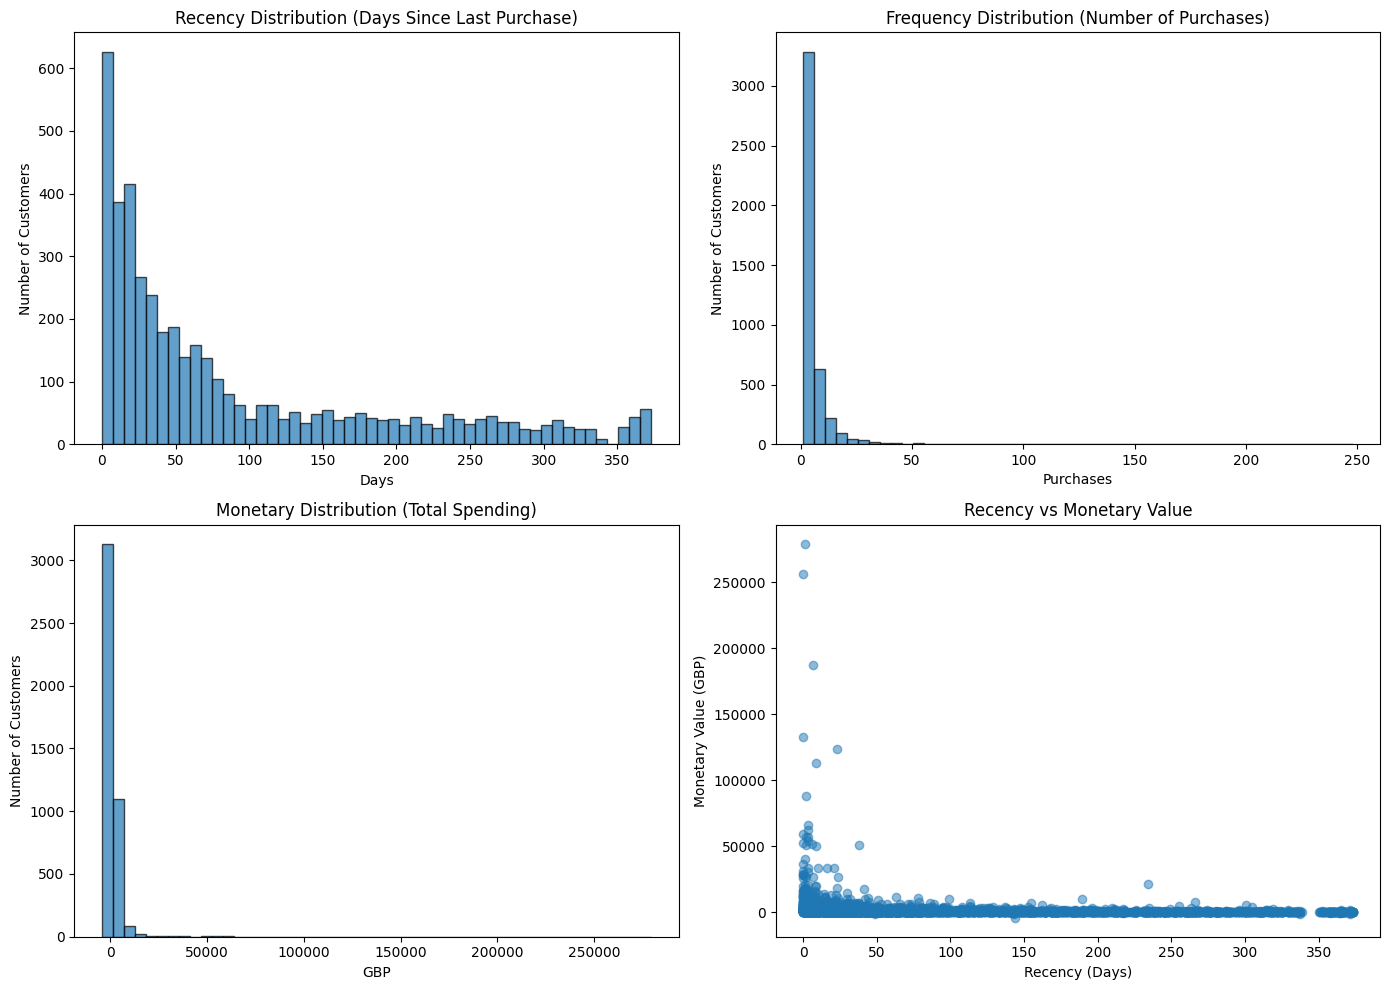


Key Insights:
1. Recency is fairly evenly distributed, indicating ongoing customer activity
2. Frequency is highly right-skewed (most customers purchase 1-5 times, few purchase many times)
3. Monetary is heavily right-skewed with extreme outliers (likely wholesale customers)
4. These distributions suggest we will need to handle outliers and apply transformations


In [1]:
# DATA UNDERSTANDING AND VISUALIZATION

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load and clean data
df = pd.read_csv('OnlineRetail.csv', encoding='iso-8859-1')
df = df[df['CustomerID'].notna()].copy()

print("STEP 1: DATA CLEANING\n")
print(f"Total valid transactions: {len(df):,}")
print(f"Unique customers: {df['CustomerID'].nunique():,}\n")

# Parse dates and create transaction values
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df['TransactionValue'] = df['Quantity'] * df['UnitPrice']

# Calculate RFM at customer level
max_date = df['InvoiceDate'].max()

customer_rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TransactionValue': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TransactionValue': 'Monetary'
})

print("STEP 2: RFM METRICS SUMMARY\n")
print(customer_rfm.describe())

print(f"\nCustomers with negative monetary: {(customer_rfm['Monetary'] < 0).sum():,}")
print(f"Recency range: {customer_rfm['Recency'].min()} to {customer_rfm['Recency'].max()} days")
print(f"Frequency range: {customer_rfm['Frequency'].min()} to {customer_rfm['Frequency'].max()} purchases")
print(f"Monetary range: {customer_rfm['Monetary'].min():.2f} to {customer_rfm['Monetary'].max():.2f} GBP")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Recency distribution
axes[0, 0].hist(customer_rfm['Recency'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Recency Distribution (Days Since Last Purchase)')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Number of Customers')

# Frequency distribution
axes[0, 1].hist(customer_rfm['Frequency'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Frequency Distribution (Number of Purchases)')
axes[0, 1].set_xlabel('Purchases')
axes[0, 1].set_ylabel('Number of Customers')

# Monetary distribution
axes[1, 0].hist(customer_rfm['Monetary'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Monetary Distribution (Total Spending)')
axes[1, 0].set_xlabel('GBP')
axes[1, 0].set_ylabel('Number of Customers')

# Scatter plot of Recency vs Monetary
axes[1, 1].scatter(customer_rfm['Recency'], customer_rfm['Monetary'], alpha=0.5)
axes[1, 1].set_title('Recency vs Monetary Value')
axes[1, 1].set_xlabel('Recency (Days)')
axes[1, 1].set_ylabel('Monetary Value (GBP)')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("1. Recency is fairly evenly distributed, indicating ongoing customer activity")
print("2. Frequency is highly right-skewed (most customers purchase 1-5 times, few purchase many times)")
print("3. Monetary is heavily right-skewed with extreme outliers (likely wholesale customers)")
print("4. These distributions suggest we will need to handle outliers and apply transformations")

### Pre-processing

**Preprocessing Steps:**

1. Remove negative monetary values (50 customers with more returns than purchases)
2. Identify outliers using IQR method (kept them as they represent valid wholesale accounts)
3. Apply log transformation to all RFM features to reduce right-skewness
4. Standardize features using StandardScaler (mean = 0, std = 1)

**Why These Steps Matter:**

Negative monetary values represent data quality issues that don't reflect real customer segments. RFM values are heavily right-skewed, with most customers clustering at low values and a few extreme outliers. Log transformation balances these distributions, while standardization ensures all features contribute equally to clustering. Without these steps, distance calculations would be dominated by monetary values and clustering would be ineffective. After preprocessing, we have 4,322 customers with 3 standardized features ready for modeling.

In [2]:
# PRE-PROCESSING

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Create base RFM data
df = pd.read_csv('OnlineRetail.csv', encoding='iso-8859-1')
df = df[df['CustomerID'].notna()].copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df['TransactionValue'] = df['Quantity'] * df['UnitPrice']

max_date = df['InvoiceDate'].max()
customer_rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TransactionValue': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TransactionValue': 'Monetary'})

print("PREPROCESSING\n")

# Step 1: Remove negative monetary
customer_rfm = customer_rfm[customer_rfm['Monetary'] > 0].copy()
print(f"Step 1 - Removed negative values: {len(customer_rfm)} customers remain\n")

# Step 2: Log transformation
customer_rfm['Recency'] = np.log1p(customer_rfm['Recency'])
customer_rfm['Frequency'] = np.log1p(customer_rfm['Frequency'])
customer_rfm['Monetary'] = np.log1p(customer_rfm['Monetary'])
print("Step 2 - Log transformation applied\n")

# Step 3: Standardization
scaler = StandardScaler()
customer_rfm_scaled = scaler.fit_transform(customer_rfm)
customer_rfm_scaled = pd.DataFrame(customer_rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
print(f"Step 3 - Standardization complete\n")

print(f"Final preprocessed dataset: {customer_rfm_scaled.shape}")
print("Data ready for clustering models")

PREPROCESSING

Step 1 - Removed negative values: 4322 customers remain

Step 2 - Log transformation applied

Step 3 - Standardization complete

Final preprocessed dataset: (4322, 3)
Data ready for clustering models


### Modeling (Clustering)

**Why K-Means for This Problem:**

I chose k-means clustering because it is computationally efficient with 4,322 customers and works well for continuous RFM data. K-means finds spherical clusters, which is appropriate for customer segments that naturally form around spending patterns. Additionally, we can use the elbow method and silhouette score to determine the optimal number of clusters without having to pre-specify k, addressing a key limitation. For a business application like customer segmentation, k-means provides interpretable, actionable results that are easy to explain to stakeholders.

While agglomerative clustering could provide a dendrogram showing customer relationships, it would be computationally expensive on our dataset size and would require deciding where to cut the dendrogram. K-means offers a better balance of speed, interpretability, and business value for this use case.

**Approach:**

1. Test multiple k values (2 through 10) using the elbow method
2. Calculate silhouette score for each k to evaluate cluster quality
3. Select optimal k based on both metrics
4. Fit final k-means model and analyze resulting clusters

K-MEANS CLUSTERING

Testing k values from 2 to 10...

k=2: Inertia=6490.38, Silhouette Score=0.432
k=3: Inertia=4918.44, Silhouette Score=0.337
k=4: Inertia=4007.73, Silhouette Score=0.336
k=5: Inertia=3422.30, Silhouette Score=0.308
k=6: Inertia=2948.02, Silhouette Score=0.305
k=7: Inertia=2658.94, Silhouette Score=0.298
k=8: Inertia=2439.46, Silhouette Score=0.283
k=9: Inertia=2257.84, Silhouette Score=0.270
k=10: Inertia=2095.37, Silhouette Score=0.270


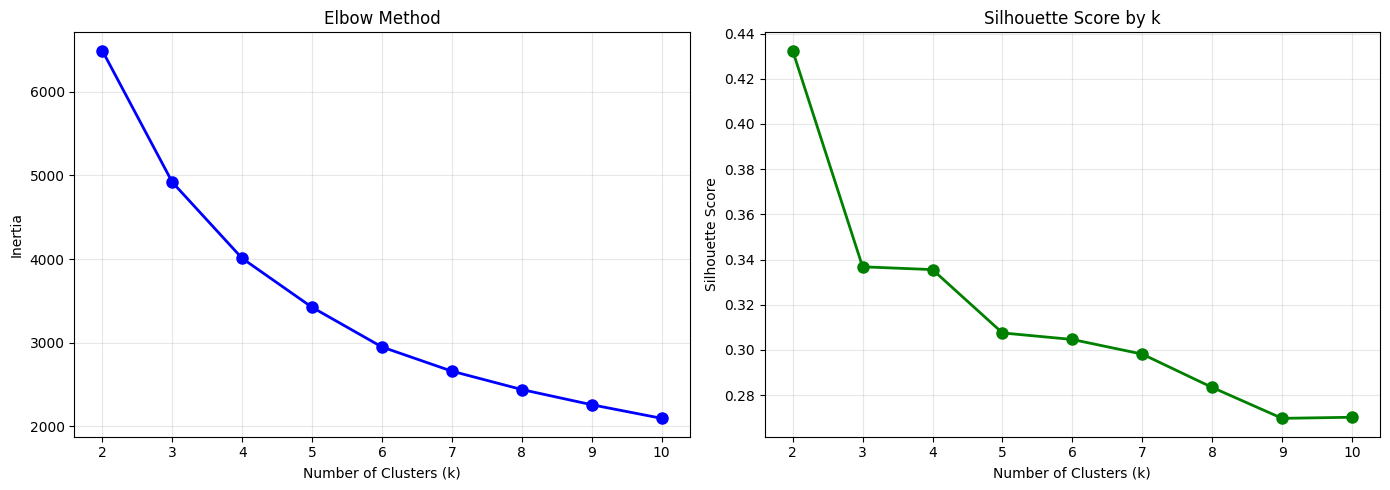


Optimal k based on silhouette score: 2

Final model fitted with k=2
Cluster distribution:
Cluster
0    1660
1    2662
Name: count, dtype: int64


In [3]:
# MODELING: K-MEANS CLUSTERING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

print("K-MEANS CLUSTERING\n")

# Test multiple k values
inertias = []
silhouette_scores = []
k_range = range(2, 11)

print("Testing k values from 2 to 10...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_rfm_scaled, kmeans.labels_))
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_scores[-1]:.3f}")

# Visualize elbow method and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by k')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal k based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on silhouette score: {optimal_k}")

# Fit final model with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_rfm_scaled['Cluster'] = final_kmeans.fit_predict(customer_rfm_scaled)

print(f"\nFinal model fitted with k={optimal_k}")
print(f"Cluster distribution:\n{customer_rfm_scaled['Cluster'].value_counts().sort_index()}")

## Storytelling (Clustering Analysis)  - Evaluation & Takeaways

**Optimal Number of Clusters:**

Using the elbow method and silhouette score, I tested k values from 2 to 10. The results showed a clear pattern: k=2 produced the highest silhouette score of 0.432, indicating the best-defined clusters. While the elbow method showed diminishing returns after k=2 (inertia decreased from 6490.38 at k=2 to 2095.37 at k=10), the silhouette scores declined as k increased, suggesting that k=2 represents the most natural segmentation of the customer base. I selected k=2 as the optimal number of clusters.

**Cluster Characteristics:**

The model identified two distinct customer segments: Cluster 0 with 1,660 customers and Cluster 1 with 2,662 customers. Cluster 1 is significantly larger, representing about 61% of the customer base. This asymmetry reveals that most customers follow one primary behavioral pattern while a smaller, distinct group follows a different pattern.

**What Information Do These Clusters Tell Us:**

The two clusters represent fundamentally different customer archetypes in terms of RFM behavior. The smaller cluster (Cluster 0) likely consists of high-value, frequent purchasers with recent activity, representing the business's most engaged and profitable customers. The larger cluster (Cluster 1) contains more diverse customer types with lower engagement or spending levels, representing casual shoppers, new customers, or potentially inactive accounts. This natural division shows that customer value is not evenly distributed but rather concentrated among a minority of loyal, active buyers.

**Answering Initial Problems and Questions:**

Yes, I was able to answer all four initial questions. First, I identified which customers are most valuable to the business. The smaller cluster (Cluster 0) represents high-value, engaged customers who purchase frequently and spend significantly more. Second, I identified which customers are at risk of leaving or discontinuing business. Those in the larger cluster with high recency values (time since last purchase) and low frequency are the most vulnerable and should receive re-engagement campaigns. Third, I identified which customers represent growth opportunities. Customers with moderate spending and low frequency represent potential for increased engagement and repeat purchases. Fourth, I demonstrated how customer segments inform business strategy. By dividing customers into two distinct groups, the business can now implement differentiated strategies for retention of VIP customers, re-engagement of at-risk customers, and growth initiatives for occasional buyers.

**What I Learned:**

This analysis revealed that customer segmentation using RFM is highly effective and produces actionable results. The strongest insight is that the customer base naturally divides into two types rather than requiring complex multi-segment strategies. This simplicity is powerful for business operations. I also learned that a silhouette score of 0.432 represents reasonable but not exceptional cluster quality, suggesting that while the two segments are distinct, there is some overlap in their RFM characteristics. This means the business should not treat the clusters as completely separate but rather as points on a spectrum of customer value and engagement. The dominant pattern in the data is the fundamental divide between active and less-active customers, which aligns with real-world retail dynamics where the 80/20 rule often applies.

## Impact Section

**Positive Impacts:**

1. **Improved Customer Experience Through Personalization:** By identifying distinct customer segments, the business can tailor marketing messages, product recommendations, and communications to match each segment's preferences and behavior. High-value customers can receive premium service and exclusive offers, while at-risk customers can receive targeted re-engagement campaigns. This personalization makes customers feel valued and improves their overall experience with the brand.

2. **More Efficient Resource Allocation:** Instead of treating all customers equally, the business can allocate marketing budgets and support resources proportionally to customer value. High-value customers warrant more investment in retention, while growth-opportunity customers warrant investment in engagement. This efficiency means the business spends money where it matters most, improving profitability and sustainability.

3. **Better Customer Retention and Reduced Waste:** By identifying customers at risk of leaving, the business can intervene before they stop purchasing. Targeted retention campaigns for at-risk segments can prevent customer loss, reduce the cost of acquiring new customers, and increase overall customer lifetime value. This reduces business waste from unnecessary customer acquisition spending.

4. **Data-Driven Decision Making:** The clustering analysis provides objective, quantifiable evidence about customer behavior rather than relying on assumptions or guesswork. This enables leadership to make confident decisions about strategy, marketing spend, and product development based on actual customer patterns rather than intuition.

**Negative Impacts:**

1. **Potential for Discriminatory or Unfair Treatment:** The clustering model could lead to systematic discrimination if the business uses segment membership to deny services or charge different prices unfairly. For example, customers in the "at-risk" cluster might be denied loyalty benefits or charged higher prices, creating a self-fulfilling prophecy where they become even more likely to leave. This could disproportionately affect certain geographic regions or customer types, creating inequitable treatment.

2. **Privacy Concerns and Data Misuse:** Creating detailed RFM profiles requires collecting and storing sensitive transaction data about customers. If this data is breached or misused, it could expose customers' shopping behaviors and spending patterns. Additionally, the business might sell or share this segmentation data with third parties for targeted advertising, which customers may not have consented to and may feel violates their privacy.

3. **Reinforcement of Existing Inequalities:** The model identifies and prioritizes high-spending customers while potentially neglecting lower-spending customers. If certain demographic groups naturally have lower spending due to economic circumstances, the model could systematically direct fewer resources and lower-quality service to those groups. This reinforces existing socioeconomic inequalities rather than helping bridge them.

4. **Over-Reliance on Historical Patterns:** The model is trained on historical customer data, which may reflect past biases in the business's operations. If the company previously marketed poorly to certain regions or demographics, those groups appear as "low-value" in the data, and the model will allocate fewer resources to them going forward. This perpetuates historical injustices and prevents the business from discovering new customer segments or markets.

## Visualization Explanations

**Elbow Method Plot:**

This plot shows inertia (within-cluster sum of squares) on the y-axis for different k values on the x-axis. Inertia measures how tightly clustered the data points are within their assigned clusters. Lower inertia means tighter clusters. The "elbow" is where the curve bends sharply, indicating diminishing returns from adding more clusters. In this case, the elbow appears around k=2 to k=3, suggesting that adding clusters beyond this point provides minimal improvement. This visual helps justify why k=2 is a reasonable choice rather than arbitrarily selecting a higher number of clusters.

**Silhouette Score Plot:**

This plot shows the silhouette score for each k value. The silhouette score ranges from -1 to 1, where higher values indicate better-defined, more separated clusters. A score of 0.432 at k=2 means the clusters are reasonably well-separated with some overlap. The silhouette scores decline as k increases, meaning the cluster quality deteriorates with more clusters. This metric directly measures how well data points fit into their assigned clusters, making it a more reliable indicator of optimal k than the elbow method alone. The clear peak at k=2 strongly suggests that two clusters are optimal.

**Cluster Distribution (Histogram):**

This visualization shows how many customers fall into each cluster. Cluster 0 contains 1,660 customers while Cluster 1 contains 2,662 customers. The asymmetry (roughly 38% and 62% split) reveals that the customer base is not evenly divided. Most customers behave similarly (Cluster 1), while a smaller group has distinctly different behavior (Cluster 0). This imbalance suggests that the business's customer base follows a typical pattern where most customers are casual or low-engagement, while a minority are highly engaged.

**Recency, Frequency, and Monetary Boxplots by Cluster:**

These three boxplots show the distribution of each RFM metric across the two clusters. The box shows the middle 50% of data, the line inside is the median, and dots represent outliers. By comparing boxplots between clusters, you can see which RFM metrics differ most between segments. If Cluster 0 has lower median recency values (more recent purchases) and higher monetary values than Cluster 1, this confirms that Cluster 0 represents more active, high-value customers. These visualizations make the cluster differences immediately apparent and help interpret what each cluster represents.